In [5]:
import torch
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

In [5]:
print("Git Ahh")

Git Ahh


In [3]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()  # Get the number of available GPUs
    current_gpu = torch.cuda.current_device()  # Get the index of the current GPU
    gpu_name = torch.cuda.get_device_name(current_gpu)  # Get the name of the current GPU
    
    # Get detailed GPU properties
    gpu_properties = torch.cuda.get_device_properties(current_gpu)
    gpu_total_memory = gpu_properties.total_memory / (1024 ** 3)  # Total memory in GB
    
    # Print GPU information
    print(f"Number of available GPUs: {num_gpus}")
    print(f"Current GPU: {gpu_name}")
    print(f"Total GPU memory: {gpu_total_memory:.2f} GB")
else:
    print("No GPU available. CUDA is not supported.")

No GPU available. CUDA is not supported.


In [7]:
torch.manual_seed(1)
N = 100000
z = torch.zeros(N)
dataType = "Gaussian"
#dataType = "logNormal"
if dataType == "Gaussian":
    x = torch.randn(N)
elif dataType == "logNormal":
    x = z.log_normal_(0,1)

# We store the mean and std deviation for later reference, they are also the MAP and MLE estimates in this case.
realMean = torch.mean(x)
realStd = torch.std(x)
print(f"Mean of x = {realMean}")
print(f"Std of x = {realStd}")

Mean of x = -0.0017340191407129169
Std of x = 1.0007357597351074


In [8]:
class MetropolisHastings():

    def __init__(self, dataset):
        self.dataset = dataset
        self.N = dataset.size(0)

    def run(self, T, theta, data):
        S = torch.zeros(T, theta.size(0))
        S[0,:] = theta
        for i in range(T-1):
            theta_new = self.get_theta_new(S[i,:])
            log_alpha = self.get_log_alpha(S[i,:],theta_new, data)
            log_u = torch.log(torch.rand(1))/ data.size(0)
            if log_u < log_alpha:
                S[i+1,:] = theta_new
            else:
                S[i+1,:] = S[i,:]
        return S

    def get_theta_new(self, theta):
        return theta + self.get_stepsize()*torch.randn(2)

    def get_log_alpha(self, theta, theta_new, data):
        lkhd = self.get_log_lkhd(theta_new, data) - self.get_log_lkhd(theta, data) # lkhd_new - lkhd_old
        return torch.mean(lkhd)

    def get_log_lkhd(self, theta, data):
        return -(((data - theta[0])/theta[1])**2)/2 - torch.log(theta[1]) # -((data-mu)/sig)**2 - log(sig)

    def get_stepsize(self):
        return 0.5/torch.sqrt(torch.tensor([self.N])) # 0.5/sqrt(N)


Execution time: 4.720661 seconds


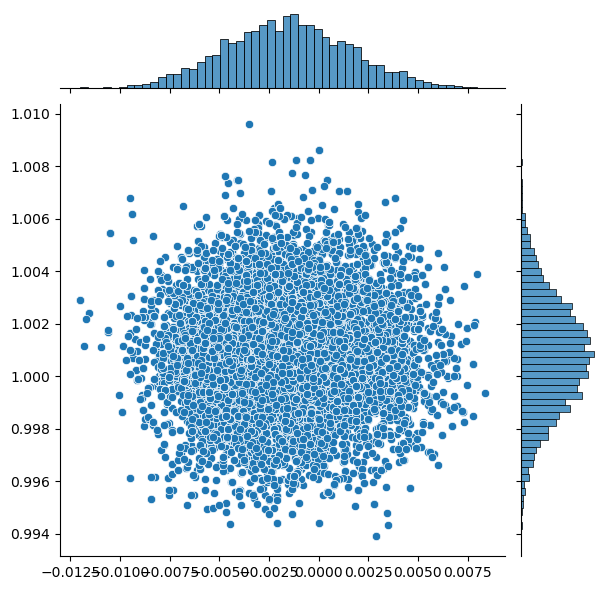

In [9]:
map = torch.tensor([realMean,realStd])
vanill = MetropolisHastings(x)

start_time = time.time()
run_vanill = vanill.run(10000, map, x)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")

sns.jointplot(x=run_vanill[:,0],y=run_vanill[:,1])

In [67]:
# class FlyMH(MetropolisHastings):

#   def run(self, T, resample_fraction):
#       z = torch.zeros(self.N * resample_fraction)
#       for i in range(len(z)):
#         n = torch.randint(low=1, high=self.N+1, size=(1,))
#         z[i] =



#       S = torch.zeros(T, self.theta.size(0))
#       S[0,:] = self.theta
#       for i in range(T-1):
#         theta_new = self.get_theta_new(S[i,:])
#         log_alpha = self.get_log_alpha(S[i,:],theta_new)
#         log_u = torch.log(torch.rand(1))/N
#         if log_u < log_alpha:
#           S[i+1,:] = theta_new
#         else:
#           S[i+1,:] = S[i,:]

#       return S

In [10]:
class consensusMH(MetropolisHastings):
    def __init__(self, num_batches, dataset):
        super().__init__(dataset)
        self.num_batches = num_batches
    
    def create_batches(self):
        batch_size = self.N // self.num_batches  # Calculate batch size

        # Create shuffled indices
        indices = torch.randperm(self.N)

        # Split shuffled indices into batches
        batches = [indices[i*batch_size:(i+1)*batch_size] for i in range(self.num_batches)]

        # Extract batches from input_tensor using shuffled indices
        batches_data = [self.dataset[batch] for batch in batches]
        return batches_data
    
    def combine_batch_samples(self, batch_sample_list):
        batch_sample_tensor = torch.stack(batch_sample_list)
        # Calculate the mean along a specific dimension (e.g., dim=0 for averaging across tensors)
        average_sample_tensor = torch.mean(batch_sample_tensor, dim=0)
        
        return average_sample_tensor
    
    def run_all_batches(self,T, theta):
        if __name__ == "__main__":
            with concurrent.futures.ThreadPoolExecutor() as executor:
                futures = [executor.submit(self.run, T, theta, batch) for batch in self.create_batches()]
                batch_sample_list = [future.result() for future in concurrent.futures.as_completed(futures)]

        S = self.combine_batch_samples(batch_sample_list)
        
        return S


Execution time: 27.858835 seconds


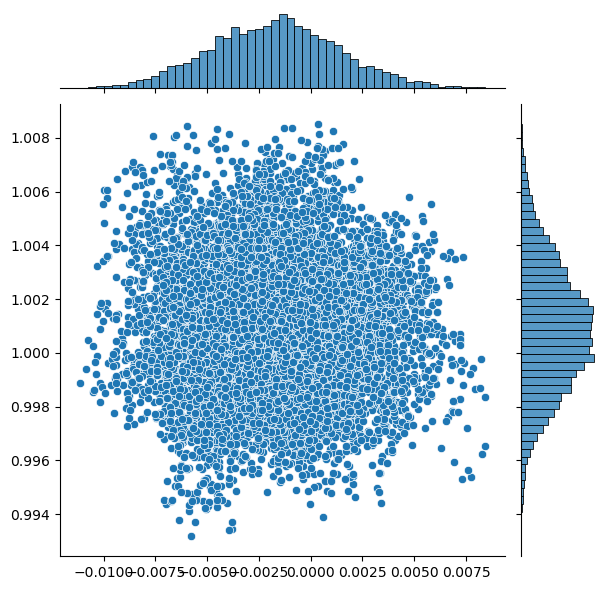

In [11]:
cons = consensusMH(dataset = x, num_batches=5)

start_time = time.time()
S = cons.run_all_batches(10000, map)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.6f} seconds")
sns.jointplot(x=S[:,0],y=S[:,1])